In [87]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import random

from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform
from typing import Tuple, List, Union
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch .utils.data import DataLoader, Dataset
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/var/folders/w7/s5mnqhhn0r5ddff08b303s3c0000gn/T/ipykernel_5263/3487035620.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 320x320 with 0 Axes>

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


/Users/iskys/venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/iskys/venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/iskys/venv/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopyth

scanpy==1.9.3 anndata==0.9.2 umap==0.5.3 numpy==1.24.2 scipy==1.9.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.10


/Users/iskys/venv/lib/python3.9/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


## Data preprocessing

In [ ]:
# Load the AnnData object containing single-cell RNA-Seq data from the specified file
data = sc.read_h5ad('COMBAT-CITESeq-EXPRESSION-ATLAS.h5ad')

# Display the loaded AnnData object
data # data - AnnData object containing single-cell RNA-Seq data

In [108]:
data.obs # Access the observation (cell) information in the AnnData object

,Source_x,GEX_region,cluster,cluster_source,minor_subset,minor_subset_source,major_subset,major_subset_source,cell_type,cell_type_source,...,PreExistingDiabetes,PreExistingHypertension,PreExistingImmunocompromised,Smoking,Symptomatic,Requiredvasoactive,Respiratorysupport,SARSCoV2PCR,Outcome,TimeSinceOnset_y
AAACCTGAGAAAGTGG-1-gPlexA1,COVID_SEV,B: TEM/prolif. T/NK cells,NK.CD16hi.1,NK.CD16hi.1_COVID_SEV,NK.CD16hi,NK.CD16hi_COVID_SEV,NK,NK_COVID_SEV,NK,NK_COVID_SEV,...,0.0,1.0,0.0,0,1.0,1.0,1.0,1,2.0,12.0
AAACCTGAGCGGATCA-1-gPlexA1,COVID_MILD,B: TEM/prolif. T/NK cells,CD8.TEMRA.1,CD8.TEMRA.1_COVID_MILD,CD8.TEMRA,CD8.TEMRA_COVID_MILD,CD8,CD8_COVID_MILD,T,T_COVID_MILD,...,0.0,0.0,0.0,0,1.0,0.0,4.0,1,5.0,12.0
AAACCTGAGGACATTA-1-gPlexA1,COVID_HCW_MILD,D: B/Plasma cells,nan,nan_COVID_HCW_MILD,nan,nan_COVID_HCW_MILD,nan,nan_COVID_HCW_MILD,nan,nan_COVID_HCW_MILD,...,NaN,NaN,NaN,0,1.0,NaN,4.0,1,6.0,17.0
AAACCTGAGGCGACAT-1-gPlexA1,COVID_CRIT,C: Monocytes/cDC,ncMono,ncMono_COVID_CRIT,ncMono,ncMono_COVID_CRIT,ncMono,ncMono_COVID_CRIT,MNP,MNP_COVID_CRIT,...,0.0,1.0,0.0,0,1.0,1.0,1.0,1,2.0,14.0
AAACCTGAGGGAACGG-1-gPlexA1,COVID_SEV,C: Monocytes/cDC,cMono.LGALS2.AHNAK,cMono.LGALS2.AHNAK_COVID_SEV,cMono,cMono_COVID_SEV,cMono,cMono_COVID_SEV,MNP,MNP_COVID_SEV,...,0.0,0.0,0.0,0,1.0,0.0,3.0,1,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTGGCAAAC-1-gPlexK7,HV,C: Monocytes/cDC,cMono.S100A8/9/12hi.HMGB2,cMono.S100A8/9/12hi.HMGB2_HV,cMono,cMono_HV,cMono,cMono_HV,MNP,MNP_HV,...,NaN,NaN,NaN,1,NaN,NaN,4.0,0,6.0,NaN
TTTGTCAGTTACCGAT-1-gPlexK7,Flu,B: TEM/prolif. T/NK cells,CD8.TEM,CD8.TEM_Flu,CD8.TEM,CD8.TEM_Flu,CD8,CD8_Flu,T,T_Flu,...,0.0,0.0,NaN,0,NaN,1.0,1.0,0,2.0,11.0
TTTGTCATCCTCTAGC-1-gPlexK7,COVID_HCW_MILD,B: TEM/prolif. T/NK cells,CD8.TEMRA.mitohi.2,CD8.TEMRA.mitohi.2_COVID_HCW_MILD,CD8.mitohi,CD8.mitohi_COVID_HCW_MILD,CD8,CD8_COVID_HCW_MILD,T,T_COVID_HCW_MILD,...,NaN,NaN,NaN,0,1.0,NaN,4.0,1,6.0,7.0
TTTGTCATCGAGGTAG-1-gPlexK7,COVID_SEV,C: Monocytes/cDC,cMono.LGALS2.PSME2.IFITM3hi,cMono.LGALS2.PSME2.IFITM3hi_COVID_SEV,cMono,cMono_COVID_SEV,cMono,cMono_COVID_SEV,MNP,MNP_COVID_SEV,...,1.0,0.0,0.0,1,1.0,0.0,5.0,1,1.0,3.0


In [ ]:
# Select only the columns with 'feature_types' equal to 'Gene Expression'
data = data[:, data.var['feature_types'] == 'Gene Expression']

In [ ]:
# Load outcome data from the file 'COMBAT_CLINVAR_for_processed.txt'
outcome_data = pd.read_csv('CBD-KEY-CLINVAR/COMBAT_CLINVAR_for_processed.txt', sep='\t')

In [ ]:
# Combine data from data.obs with outcome data based on 'scRNASeq_sample_ID'
merge_data = data.obs.merge(outcome_data, on='scRNASeq_sample_ID', how='left')

# Set the indices of the merged data to be the same as the original data
merge_data.index = data.obs.index

#Update the data.obs with the merged data
data.obs = merge_data

In [ ]:
print(data.X[:30, :30])  # Checking that the data is normalized

In [ ]:
# Calculate highly variable genes (HVG) using the specified parameters
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVG

In [ ]:
# Visualize highly variable genes
sc.pl.highly_variable_genes(data)

In [ ]:
# Selecting a subset of data using boolean indexing
# data.var.highly_variable - a boolean array indicating highly variable genes
# data[:, data.var.highly_variable] - selecting all rows and only highly variable genes
data = data[:, data.var.highly_variable]

In [ ]:
# Perform data scaling using the sc.pp.scale() function on the AnnData object.
# This scaling applies z-score transformation to the data, which involves subtracting the mean and dividing by the standard deviation.
# Additionally, the data is transformed to have a mean of 0 and a standard deviation of 1.
# The max_value=10 option limits the scaling such that values after scaling do not exceed 10.
sc.pp.scale(data, max_value=10)

In [ ]:
# Calculate PCA for the data
# data: AnnData object containing the data matrix
# svd_solver: method used for PCA computation (default is 'arpack')
sc.tl.pca(data, svd_solver='arpack')

# Visualize PCA
# data: AnnData object containing the data matrix
# color: metadata column used for coloring the plot
sc.pl.pca(data, color='CST3')

In [110]:
# Save data
data.write('COMBAT_EXPRESSION_MY.h5ad')

In [28]:
data = sc.read_h5ad('COMBAT_EXPRESSION_MY')

In [109]:
data

AnnData object with n_obs × n_vars = 836148 × 958
    obs: 'Source_x', 'GEX_region', 'cluster', 'cluster_source', 'minor_subset', 'minor_subset_source', 'major_subset', 'major_subset_source', 'cell_type', 'cell_type_source', 'COMBAT_ID_x', 'scRNASeq_sample_ID', 'Age_x', 'Sex_x', 'Hospitalstay_x', 'TimeSinceOnset_x', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_clone_count', 'TCR_clone_proportion', 'BCR_total_mut_HC', 'BCR_clonal_abundance_HC', 'BCR_total_mut_LC', 'row_number', 'COMBAT_participant_timepoint_ID', 'COMBAT_ID_y', 'RNASeq_sample_ID', 'CyTOF_sample_ID', 'COMBAT_Luminex_sample_ID', 'COMBAT_proteomics_sample_ID', 'COMBAT_antibody_data_ID', 'ATAC_sample_ID', 'COMBAT_genotype_ID', 'Source_y', 'Age_y', 'Sex_y', 'BMI', 'Hospitalstay_y', 'Death28', 'Institute', 'PreExistingHeartDisease', 'PreExistingLungDisease', 'PreExistingKidneyDisease', 'PreExistingDiabetes', 'PreExistingHypertension', 'PreExistingImmunocompromised', 'Smoking', 'Symptomat

In [24]:
unique_categories = data.obs['scRNASeq_sample_ID'].unique()

AnnData object with n_obs × n_vars = 836148 × 958
    obs: 'Source_x', 'GEX_region', 'cluster', 'cluster_source', 'minor_subset', 'minor_subset_source', 'major_subset', 'major_subset_source', 'cell_type', 'cell_type_source', 'COMBAT_ID_x', 'scRNASeq_sample_ID', 'Age_x', 'Sex_x', 'Hospitalstay_x', 'TimeSinceOnset_x', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_clone_count', 'TCR_clone_proportion', 'BCR_total_mut_HC', 'BCR_clonal_abundance_HC', 'BCR_total_mut_LC', 'row_number', 'COMBAT_participant_timepoint_ID', 'COMBAT_ID_y', 'RNASeq_sample_ID', 'CyTOF_sample_ID', 'COMBAT_Luminex_sample_ID', 'COMBAT_proteomics_sample_ID', 'COMBAT_antibody_data_ID', 'ATAC_sample_ID', 'COMBAT_genotype_ID', 'Source_y', 'Age_y', 'Sex_y', 'BMI', 'Hospitalstay_y', 'Death28', 'Institute', 'PreExistingHeartDisease', 'PreExistingLungDisease', 'PreExistingKidneyDisease', 'PreExistingDiabetes', 'PreExistingHypertension', 'PreExistingImmunocompromised', 'Smoking', 'Symptomat

In [ ]:
# Dictionary to store generated DataFrames
random_1000 = {}

# Generate two DataFrames with random subsets of 1000 rows for each unique element
for value in unique_categories:
    # Get donor data for the current unique element
    donor_data = data.obsm['X_pca'][data.obs['scRNASeq_sample_ID'] == value]
    
    # Check if there are enough elements for sampling
    if donor_data.shape[0] >= 1000:
        # Randomly select indices without replacement for the first subset
        random_indices_1 = np.random.choice(donor_data.shape[0], size=1000, replace=False)
        # Randomly select indices without replacement for the second subset
        random_indices_2 = np.random.choice(donor_data.shape[0], size=1000, replace=False)
    else:
        # If there are fewer than 1000 elements, use all available indices
        random_indices_1 = np.arange(donor_data.shape[0])
        random_indices_2 = np.arange(donor_data.shape[0])
    
    # Compute the mean of the first subset
    random_sample_1 = donor_data[random_indices_1].mean(axis=0)
    # Select the second subset using the random indices
    random_sample_2 = donor_data[random_indices_2]
    
    # Store the generated subsets in the dictionary
    random_1000[value] = (random_sample_1, random_sample_2)


In [ ]:
def calculate_distance_matrix(data, ID):
    """
    Calculates a pairwise distance matrix between donors based on data from X_pca.
    Parameters:
        data (AnnData): AnnData object containing the X_pca data matrix.
        ID (str): Identifier of the column in data.obs used for donor grouping.
    Returns:
        pd.DataFrame: Pairwise distance matrix between donors.
    """
    donors = {}
    unique_categories = data.obs[ID].unique()
    
    # Calculate the mean representation for each donor
    for category in unique_categories:
        donor_representation = data.obsm['X_pca'][data.obs[ID] == category]
        donors[category] = donor_representation.mean(axis=0)
    
    # Create a DataFrame of donor representations
    data_donors = pd.DataFrame(donors).T
    
    # Calculate pairwise distances and create a distance matrix
    distances = pdist(data_donors.values)
    distance_matrix = squareform(distances)
    distance_df = pd.DataFrame(distance_matrix, index=data_donors.index, columns=data_donors.index)
    
    return distance_df, data_donors

# Calculate and print the distance matrix
distance_matrix, data_donors = calculate_distance_matrix(data, 'scRNASeq_sample_ID')
print(distance_matrix)


In [ ]:
print(data_donors)

## Contrastive learnin

In this part of the notebook, we build a neutron network by adjusting the hyperparameters such as depth (adjustable by **num_layers_values**), number of neurons in a layer (**hidden_size_values**), match size (**batch_sizes**). We also select a different number of cells for each patient to build the pseudo-bulk, which is also an adjustable parameter.

In [6]:
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Global seed set to 42


Device: cpu
Number of workers: 8


In [91]:
class SamplesDataset(Dataset):
    def __init__(self, data, unique_categories: List[str], sample_col: str, layer: str = "X_pca"):
        """
        A dataset that holds sample cells based on unique categories.

        Args:
            data (YourDataType): The dataset containing the data.
            unique_categories (List[str]): List of unique category values.
            sample_col (str): The column indicating sample information.
            layer (str, optional): The data layer to be used. Defaults to "X_pca".
        """
        self.data = data
        self.unique_categories = unique_categories
        self.sample_cells = []
        self.sample_col = sample_col
        self.layer = layer
        
        for sample_id in self.unique_categories:
            sample = self.data.obsm[layer][self.data.obs[sample_col] == sample_id]
            self.sample_cells.append(sample)

    def __len__(self):
        return len(self.unique_categories)

    def __getitem__(self, idx):
        return self.sample_cells[idx]
    

class TransformedPairDataset(Dataset):
    """Create two different subsamples based on one sample from the original dataset."""

    def __init__(self, dataset: Dataset, subset_size: int = 1000):
        """
        Initialize a dataset with transformed pairs.
        Args:
            dataset (Dataset): The input dataset.
            subset_size (int, optional): Size of the transformed subset. Defaults to 1000.
        """
        self.dataset = dataset  # The input dataset
        self.subset_size = subset_size  # Size of the transformed subset

    def __len__(self):
        """
        Get the length of the dataset.
        Returns:
            int: The length of the dataset.
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Get a pair of transformed subsamples based on the original sample.
        Args:
            idx (int): Index of the original sample.
        Returns:
            tuple: A tuple containing two transformed subsamples.
        """
        sample = self.dataset[idx]  # Get the original sample
        
        # Randomly select indices for the transformed subsamples
        random_indices_1 = np.random.choice(sample.shape[0], size=self.subset_size)
        random_indices_2 = np.random.choice(sample.shape[0], size=self.subset_size)

        # Compute the mean of the selected indices to create transformed subsamples
        random_sample_1 = sample[random_indices_1].mean(axis=0)
        random_sample_2 = sample[random_indices_2].mean(axis=0)
        
        return random_sample_1, random_sample_2


class DynamicNetwork(nn.Module):
    def __init__(self, n_input_features: int, n_output_features: int, num_layers: int, hidden_size: int):
        """
        Initialize a dynamic neural network.

        Args:
            n_input_features (int): Number of input features.
            n_output_features (int): Number of output features.
            num_layers (int): Number of hidden layers.
            hidden_size (int): Size of the hidden layers.
        """
        super().__init__()

        layers = []
        for _ in range(num_layers):
            
            # Add a linear layer followed by a ReLU activation
            layers.extend([
                nn.Linear(n_input_features, hidden_size),
                nn.ReLU()
            ])
            n_input_features = hidden_size  # Update the number of input features for the next layer

        # Add the final linear layer
        layers.append(nn.Linear(hidden_size, n_output_features))

        # Create a sequential module with the defined layers
        self.fc = nn.Sequential(*layers) # скелет

    def forward(self, x):
        """
        Forward pass through the neural network.
        Args:
            x (tensor): Input data.
        Returns:
            tensor: Output of the network.
        """
        return self.fc(x)
    


class InfoNCECauchy(nn.Module):
    def __init__(self, temperature: float = 1):
        super().__init__()
        self.temperature = temperature

    def forward(self, features):
        
        # Calculate the batch size by dividing the total feature size by 2
        batch_size = features.size(0) // 2
        
        # Split the input features into two parts: a and b
        a = features[:batch_size]
        b = features[batch_size:]
        
        # Compute the pairwise similarities for same-domain (a-a) and different-domain (a-b, b-b) pairs
        sim_aa = 1 / (torch.cdist(a, a) * self.temperature).square().add(1)
        sim_bb = 1 / (torch.cdist(b, b) * self.temperature).square().add(1)
        sim_ab = 1 / (torch.cdist(a, b) * self.temperature).square().add(1)

        # Calculate the tempered alignment term using the logarithm of the diagonal of sim_ab
        tempered_alignment = torch.diagonal_copy(sim_ab).log_().mean()

        # Exclude self inner product by masking the diagonal elements
        self_mask = torch.eye(batch_size, dtype=bool, device=sim_aa.device)
        sim_aa.masked_fill_(self_mask, 0.0)
        sim_bb.masked_fill_(self_mask, 0.0)
        
        # Calculate the logsumexp terms for both combinations of similarities
        logsumexp_1 = torch.hstack((sim_ab.T, sim_bb)).sum(1).log_().mean()
        logsumexp_2 = torch.hstack((sim_aa, sim_ab)).sum(1).log_().mean()
        
        # Compute the raw uniformity as the sum of logsumexp terms
        raw_uniformity = logsumexp_1 + logsumexp_2
        
        # Calculate the final loss as the negative difference between tempered alignment and raw uniformity
        loss = -(tempered_alignment - raw_uniformity / 2)
        return loss

Let's see how many cells we can take.

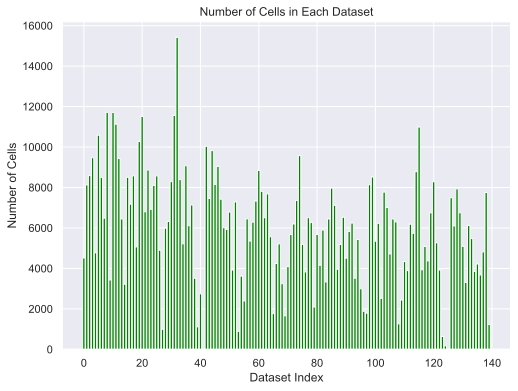

In [62]:
num_of_cells = []
for sample in dataset:
    num_of_cells.append(len(sample))

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(num_of_cells)), num_of_cells, color='green')

# Customize axis labels and title
plt.xlabel('Dataset Index')
plt.ylabel('Number of Cells')
plt.title('Number of Cells in Each Dataset')

# Show the bar chart
plt.show()


<Axes: ylabel='Count'>

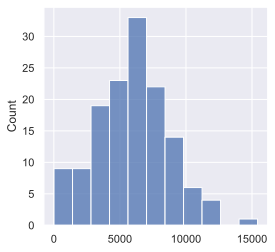

In [63]:
sns.histplot(num_of_cells)

In [64]:
np.median(num_of_cells)

6114.0

It was decided that more than 6000 cells, which is almost equal to the median, it does not make sense to take.

In [26]:
means_for_all_cells = []

# Iterate through the dataset to calculate the mean of each data sample along the rows (axis=0)
for data in dataset:
    means_for_all_cells.append(data.mean(axis=0))
    
# Convert the list of means into a NumPy array and then into a PyTorch tensor
means_for_all_cells = torch.tensor(np.array(means_for_all_cells))

In [21]:
model_folder = './Models/'
representation_folder = './Representations/'

In [82]:
# Hyperparameters
learning_rate = 0.001
batch_sizes = [16, 32, 64]
num_epochs = 1000
num_layers_values = [3, 5, 11]
hidden_size_values = [10, 100, 300]

# Create dataset and dataloader
dataset = SamplesDataset(data, unique_categories, sample_col="scRNASeq_sample_ID")
pairs_dataset = TransformedPairDataset(dataset, subset_size=1000)
criterion = InfoNCECauchy()

# Iterate over batch sizes
for batch_size in batch_sizes:
    # Iterate over num_layers values
    for num_layers in num_layers_values:
        # Iterate over hidden_size values
        for hidden_size in hidden_size_values:
            # Initialize the network and optimizer
            network = DynamicNetwork(n_input_features=50, n_output_features=30, num_layers=num_layers, hidden_size=hidden_size)
            network.to(device)
            optimizer = optim.Adam(network.parameters(), lr=learning_rate)

            dataloader = DataLoader(pairs_dataset, batch_size=batch_size, shuffle=True)

            # Training loop
            for epoch in range(num_epochs):
                for batch_idx, (batch) in enumerate(dataloader):
                    optimizer.zero_grad()
                    samples = torch.vstack((data1, data2)).to(device)
                    features = network(samples)
                    loss = criterion(features)
                    loss.backward()
                    optimizer.step()

            representation = []
            with torch.no_grad():
                representation = network(means_for_all_cells).numpy()

            # Save the model and representation (CSV)
            model_folder = "models"  # Change to your desired folder path
            representation_folder = "representations"  # Change to your desired folder path

            # Save the model state to a file
            model_name = f"model_{batch_size}_{num_layers}_{hidden_size}_1000.pt"
            save_path = os.path.join(model_folder, model_name)
            torch.save(network.state_dict(), save_path)

            # Save the representation as a CSV file
            representation_df = pd.DataFrame(representation)
            representation_name = f"representation_{batch_size}_{num_layers}_{hidden_size}_1000.csv"
            representation_path = os.path.join(representation_folder, representation_name)
            representation_df.to_csv(representation_path, index=False)


In [ ]:
distance_matrix = cdist(representation, representation, metric='euclidean')
print(distance_matrix)

In [ ]:
# Визуализация тепловой карты
plt.imshow(distance_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
clean_data = pd.read_csv('clean_table.txt', sep='\t')

In [ ]:
sns.scatterplot(x=representation[:, 0], y=representation[:, 1], hue=clean_data['Outcome'], palette='Set2')